In [38]:
# %matplotlib inline
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib import colormaps


from astropy.io import fits
from IPython.display import HTML
from hcipy import *

from iefc_utils import *

# import iefc_utils

import sys
import os

sys.path.append('/home/jasper/Documents/HCIPy_scripts/magaox-iefc-sim/')
plt.style.use('spieposter')

# PLOT_DIR = '/home/jasper/Documents/HCIPy_scripts/scc-sims/Data'
PLOT_DIR = '/home/jasper/Documents/HCIPy_scripts/scc-sims/Data_new3'



In [2]:
# Set units

pupil_diameter = 6.5
wavelength = 750e-9 # m
effective_focal_length = 1

spatial_resolution = wavelength / pupil_diameter
sr = spatial_resolution


pupil_grid = make_pupil_grid(256, diameter=1.2*pupil_diameter)    # Pad the grid to offer a bit more room

# sim 0 to 10 seconds
uniform_grid = make_uniform_grid([256, 256, 100], extent=[1.2*pupil_diameter, 1.2*pupil_diameter, 10]).shifted([0, 0, 10/2])


focal_grid = make_focal_grid(q=5, num_airy=25, spatial_resolution = wavelength/pupil_diameter)

# focal_grid = make_focal_grid(q=4, num_airy=16, spatial_resolution = wavelength/pupil_diameter)


prop = FraunhoferPropagator(pupil_grid, focal_grid, focal_length=effective_focal_length)

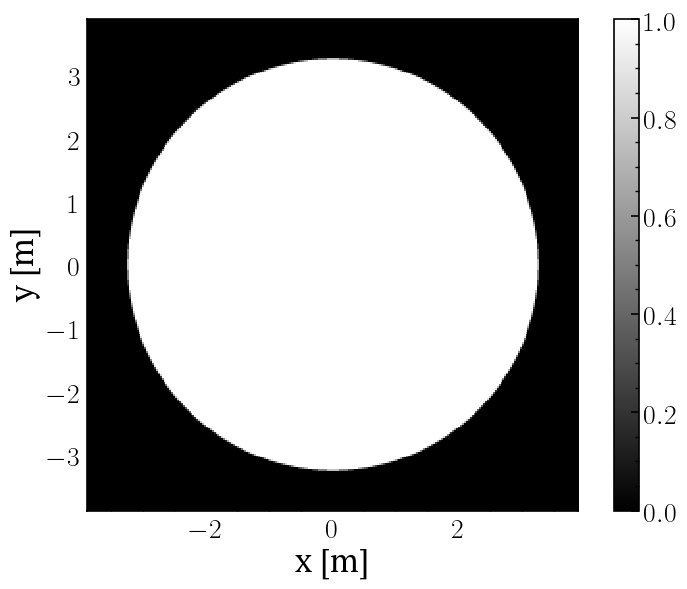

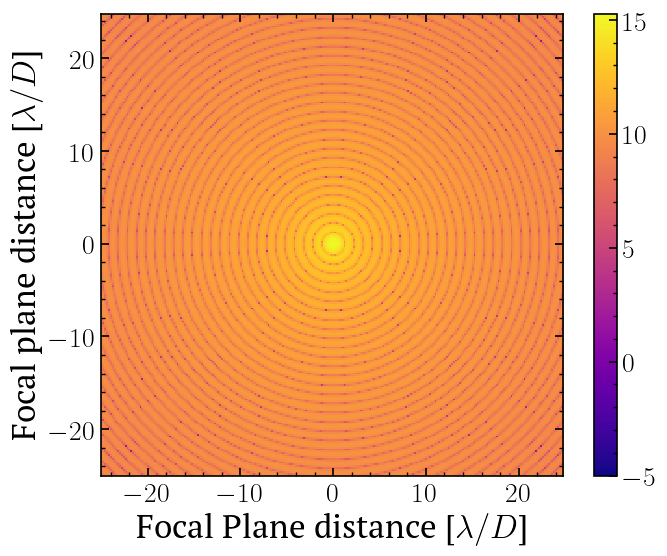

In [3]:
telescope_pupil_circ = evaluate_supersampled(make_circular_aperture(pupil_diameter), pupil_grid, 4)

# Plot telescope  pupil
imshow_field(telescope_pupil_circ, cmap='gray',)
plt.colorbar()
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.tight_layout()
# plt.savefig('../mag_ap.svg', transparent=True)
plt.show()

wavefront = Wavefront(telescope_pupil_circ, wavelength)

wavefront.total_power = 1

focal_image = prop.forward(wavefront)

norm = focal_image.power.max()

# Plot PSF
imshow_field(np.log10(focal_image.intensity / norm), vmin=-5, grid_units=sr)
# save_field('magellan_pup.svg', np.log10(focal_image.intensity / norm))
plt.xlabel('Focal Plane distance [$\lambda / D$]')
plt.ylabel('Focal plane distance [$\lambda / D$]')
plt.colorbar()
plt.show()

In [4]:
######## Initialize Lyot stop + vortex CG
lyot_mask = evaluate_supersampled(make_circular_aperture(0.95*pupil_diameter), pupil_grid, 4) # Generate undersized Lyot stop
# Note: This should be opaque!
# focal_plane_mask = 1 - evaluate_supersampled(make_circular_aperture(6*sr), coro_focal_grid, 4) # Define FPM w/ diameter of 6 lambda/D and oversampled CG grid

lyot_stop = Apodizer(lyot_mask)

# Generate a Lyot CG on the oversample CG grid
# order = 2
# coro_lyot = LyotCoronagraph(pupil_grid, focal_plane_mask, lyot_stop,  focal_plane_mask_grid=coro_focal_grid)


############ Initialize Vortex CG
# charge = 6                      # Generate a charge 6 Vortex CG
charge = 4
coro_vortex = VortexCoronagraph(pupil_grid, charge=charge)

# coro_vortex = VectorVortexCoronagraph(charge=charge, lyot_stop=None)

In [5]:
#  Construct 1k DM
num_actuators_across_pupil = 34
actuator_spacing = pupil_diameter / num_actuators_across_pupil
influence_functions = make_gaussian_influence_functions(pupil_grid, num_actuators_across_pupil, actuator_spacing, x_tilt=np.rad2deg(45))
deformable_mirror = DeformableMirror(influence_functions)
num_modes = deformable_mirror.num_actuators

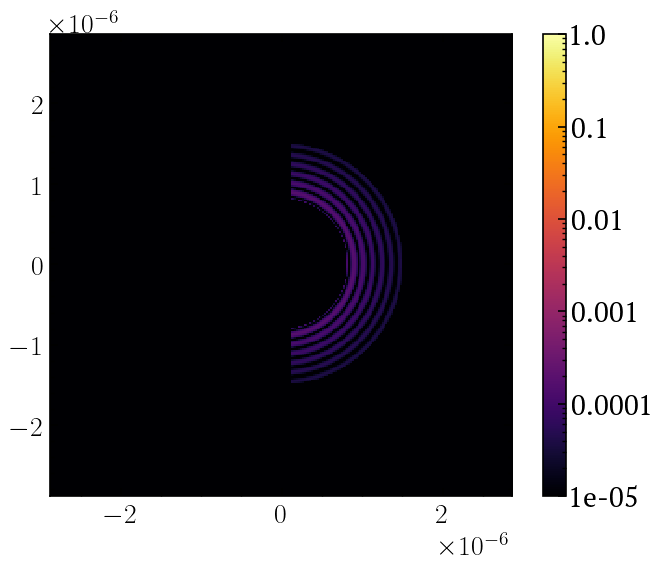

In [6]:
# Define control region

Dtel = 6.5
fourier_grid = make_pupil_grid(32, 32)        # Define grid
response_matrices_selected = []


# fourier_mask = (fourier_grid.as_('polar').r < 10) * (fourier_grid.as_('polar').r > 2)   # Overlay modes from 2-10 lambda/d
# fourier_mask *= fourier_grid.x > 0

# focal_mask = (focal_grid.as_('polar').r < 9*sr) * (focal_grid.as_('polar').r > 3*sr)    # We prev. defined as 1 lambda/D
# focal_mask *= focal_grid.x > 1*sr

wavefront_circ = Wavefront(telescope_pupil_circ, wavelength)

wavefront_circ.total_power = 1

fourier_mask = (fourier_grid.as_('polar').r < 14) * (fourier_grid.as_('polar').r > 6)   #  Overlay modes from 6-14 lambda/d

# fourier_mask = (fourier_grid.as_('polar').r < 11) * (fourier_grid.as_('polar').r > 6)   
fourier_mask *= fourier_grid.x > 0

focal_mask = (focal_grid.as_('polar').r < 13*sr) * (focal_grid.as_('polar').r > 7*sr) 

# focal_mask = (focal_grid.as_('polar').r < 10*sr) * (focal_grid.as_('polar').r > 7*sr) 

focal_mask *= focal_grid.x > 1*sr

focal_image_circ = prop.forward(wavefront_circ)

dark_hole_pixels_circ = focal_image_circ.power*focal_mask

imshow_psf(dark_hole_pixels_circ/focal_image_circ.power.max() + 1e-16, vmax=1, vmin=1e-5)
plt.show()

fourier_basis = make_fourier_basis(pupil_grid, fourier_grid.scaled(2 * np.pi / Dtel))   

# Select Fourier modes that fall within DH
selected_modes = fourier_grid.subset(fourier_mask>0)     

fourier_basis_selected = make_fourier_basis(pupil_grid, selected_modes.scaled(2 * np.pi / Dtel))   # Basis w/ seelected Fourier modes from control region

fourier_dm = DeformableMirror(fourier_basis)
fourier_dm_selected = DeformableMirror(fourier_basis_selected)  # Create DM w/ only the selected modesw from control region

In [7]:
response_matrices_selected = np.load('./jacobian_pwp_circ_ap_7_13.npy')

reconstruction_matrices_selected = np.load('./rec_mat_pwp_svc_circ_ap_7_13_reg_0.01.npy')


In [8]:
response_matrices_selected.shape

(1, 504, 8848)

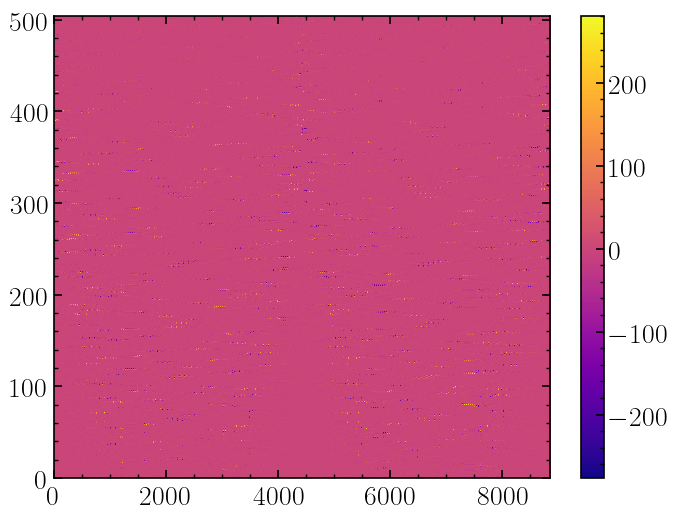

In [9]:
plt.imshow(response_matrices_selected[0],aspect='auto')
plt.colorbar()
plt.show()

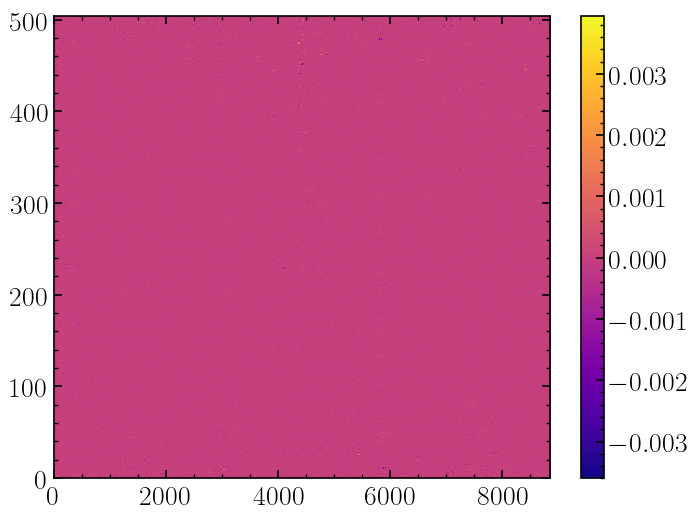

In [10]:
plt.imshow(reconstruction_matrices_selected[0],aspect='auto')
plt.colorbar()
plt.show()

In [44]:
def run_iefc_pwp(trial=1, rcond=0.01, num_iterations=20, efc_gain=0.5, aberrations=0.1, alpha=4, beta=2, u0=0.1, f0=0.1, dark_hole_pixels=dark_hole_pixels_circ, sa_optic=None, rec_mat_selected=reconstruction_matrices_selected[0], save_data=False):

    fourier_dm_selected.flatten()
    deformable_mirror.flatten()


    wf = Wavefront(telescope_pupil_circ, wavelength) # Reference WF

    wf.total_power = 1

    actuator_cmds = np.zeros(fourier_dm_selected.num_actuators)

    current_cmds = []
    image_cube = []
    mean_ni = []

    # needs to be ordered in this way or PWP doesn't work
    optical_system = OpticalSystem([coro_vortex, lyot_stop, prop])

    norm = prop(wf).power.max()

    if sa_optic is None:
        zmodes = make_zernike_basis(3, Dtel, pupil_grid)
        sa_optic = SurfaceAberration(pupil_grid, aberrations * wavelength, Dtel, exponent=-2.5, refractive_index=-1, aperture=telescope_pupil_circ, remove_modes=zmodes)   # Apply 1/10 lambda of surface aberration
        image_cube.append(optical_system(fourier_dm_selected(sa_optic(wf))).power / norm)
    else:
        image_cube.append(optical_system(fourier_dm_selected(sa_optic[0](wf))).power / norm)


    imperfect_pwp_sensor = make_pairwise_probing_sensorSCC(probe_1=400, probe_2=401, probe_amp=0.01*wavelength, dm=deformable_mirror, optical_system=optical_system)


    # take 4 images per WFC iteration
    for i in range(num_iterations//4):
        if type(sa_optic) is list:
            wf_output4 = [fourier_dm_selected(sa_optic[4*i+j](wf)) for j in range(4)]
        else:
            wf_output = fourier_dm_selected(sa_optic(wf))

        # wf_output4 = fourier_dm_selected(sa_optic[i:i+4](wf))
        # print(wf_output)
        # imperfect_pwp_sensor = make_pairwise_probing_sensor(probe_1=400, probe_2=401, probe_amp=0.01*wavelength, dm=deformable_mirror, optical_system=optical_system)
        diff_images = imperfect_pwp_sensor(wf_output4)  # Perform PWP

        # imshow_field(diff_images[-1], focal_grid)

        # break
        pwp_measurement = extract_measurement_from_difference_images(diff_images, dark_hole_pixels>0) # Extract diff images

        ef_error = rec_mat_selected.dot(pwp_measurement) # Transform WF sensing measurement into DM pattern that gives us error
        actuator_cmds -= efc_gain*ef_error # Apply opposite phase to DM so as to cancel E-field

        fourier_dm_selected.actuators = actuator_cmds
        
        print(actuator_cmds) # Check that actuator cmds are ~1e-9

        if type(sa_optic) is list:
            image_cube.append(optical_system(fourier_dm_selected(sa_optic[i](wf))).power / norm)
        else:            
            image_cube.append(optical_system(fourier_dm_selected(sa_optic(wf))).power / norm)


    mean_ni = [np.mean(image[dark_hole_pixels>0]) for image in image_cube]
    mean_ni = np.array(mean_ni)

    image_cube_field = Field(image_cube, focal_grid)  
   
    if save_data:
       # Uncomment if saving the individual images
        write_field(image_cube_field, f'{PLOT_DIR}/pwp_{alpha}_{beta}_{u0}_{f0}_aberr_{aberrations}_reg_{rcond}_trial_{trial}.fits')
        np.save(f'{PLOT_DIR}/pwp_ni_{alpha}_{beta}_{u0}_{np.round(f0, 3)}_aberr_{aberrations}_reg_{rcond}_trial_{trial}.npy', mean_ni)
    return image_cube_field, mean_ni  # TT.actuators


In [45]:
f0_list = np.linspace(0.2, 1, 5)
# for i in 

In [46]:
f0_list

array([0.2, 0.4, 0.6, 0.8, 1. ])

In [47]:
alpha = 4
beta = 2
u0 = 1 # outer scale of turbulence
# ptv = 0.1*wavelength
aberrations = 0.1
ptv = aberrations*wavelength
n_itrs = 100
# f0 = 0.1 # outer scale of temporal variations (seconds), increasing f0 increases speckle lifetime
for i in f0_list:
    PSD = time_varying_aberrations(0.1*wavelength, alpha, beta, u0, i)
    psd_wf = PSD(uniform_grid)
    sa_screen = psd_2_screen(PSD, aperture=telescope_pupil_circ, ptv=ptv)
    sa_opt, sa_field = sa_screen(pupil_grid, uniform_grid)
    # imshow_field(sa_field[3], pupil_grid)
    # plt.colorbar()
    img_cube, mean_ni = run_iefc_pwp(trial='1', rcond=1e-2, num_iterations=n_itrs, efc_gain=0.4, aberrations=aberrations, u0=u0, f0=i, dark_hole_pixels=dark_hole_pixels_circ, sa_optic=sa_opt, rec_mat_selected=reconstruction_matrices_selected[0], save_data=True)

[-2.21505197e-10 -5.13482611e-11  2.14781175e-10  1.21219923e-12
  1.73501520e-10  1.81147395e-10 -4.37331944e-10  1.18832139e-10
 -4.68557515e-10 -3.48079555e-11  7.45246377e-11 -3.90845879e-12
 -3.42713584e-10 -6.62478523e-11 -2.29744436e-10  1.83371136e-10
  1.63299424e-10  3.38839738e-10 -1.45629770e-11  5.06037376e-11
 -1.46919257e-10  1.00233314e-10 -8.36792320e-13 -7.75826312e-11
  1.82539911e-10  1.74107078e-10 -9.38353712e-11 -1.25772959e-10
  2.95685978e-11  1.05584124e-10  5.71096586e-11  1.07762836e-11
 -2.42925287e-10 -1.68339049e-10 -8.43740812e-11  1.52693726e-10
  5.18951449e-11  2.07357432e-11 -7.67518383e-11  5.31025346e-11
  7.24244447e-11  4.56339248e-11  3.65053417e-10  9.52225571e-11
 -1.15895113e-10  7.58625287e-11  2.58206523e-10  1.39962321e-11
 -1.69211507e-10  2.17446980e-11  9.40469952e-11 -4.70960735e-12
  1.25217339e-10 -2.80245616e-11 -1.44855340e-10 -4.74530190e-11
  2.17492404e-10 -4.53776887e-11 -7.89091370e-11 -3.31376903e-11
 -1.44022539e-10 -3.42304

In [35]:
mean_ni

array([3.76204206e-06, 1.50792735e-06, 6.17826678e-07, 2.69497676e-07,
       1.39437719e-07, 9.83075344e-08, 9.62260360e-08, 1.15817834e-07,
       1.52527046e-07, 2.05874187e-07, 2.75527644e-07, 3.58880427e-07,
       4.50109705e-07, 5.41021557e-07, 6.22022779e-07, 6.84255841e-07,
       7.21134456e-07, 7.29477903e-07, 7.10284860e-07, 6.68384719e-07,
       6.10867340e-07, 5.45453401e-07, 4.79204821e-07, 4.17663784e-07,
       3.64084921e-07, 3.19181488e-07])

In [42]:
mean_ni_f0_orig = np.load(PLOT_DIR + '/pwp_ni_4_2_1_0.25_aberr_0.1_reg_0.01_trial_1a.npy')

In [43]:
mean_ni

array([5.39202971e-06, 2.10102598e-06, 1.04793723e-06, 7.15754997e-07,
       7.10463060e-07, 9.55016532e-07, 1.42367712e-06, 2.01642833e-06,
       2.53485578e-06, 3.01193637e-06, 3.48733075e-06, 4.12507596e-06,
       4.84090217e-06, 5.57621385e-06, 6.19664888e-06, 6.67936207e-06,
       7.15937040e-06, 7.49089731e-06, 7.41531038e-06, 7.26988355e-06,
       7.20534391e-06, 7.47013110e-06, 8.22294520e-06, 9.14890491e-06,
       9.07206508e-06, 8.41860006e-06])

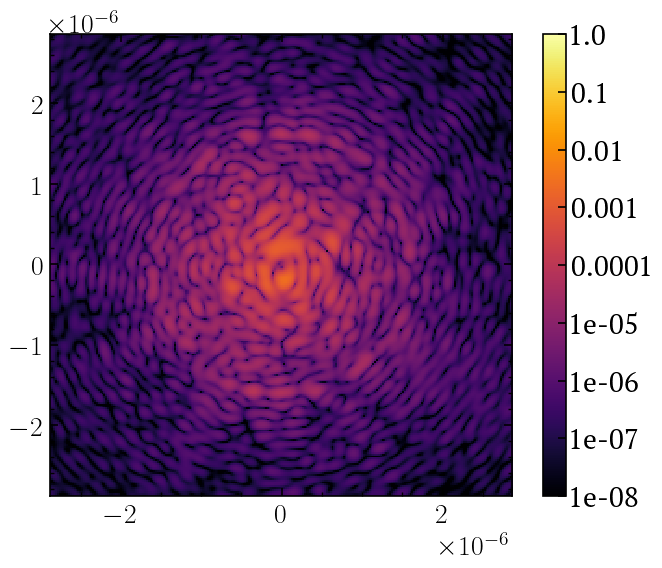

In [58]:
imshow_psf(img_cube[-1], vmax=1)

In [14]:
zmodes = make_zernike_basis(3, Dtel, pupil_grid)
aberrations = 0.1

sa_optic_circ = SurfaceAberration(pupil_grid, aberrations * wavelength, Dtel, exponent=-2.5, refractive_index=-1, aperture=telescope_pupil_circ, remove_modes=zmodes)   # Apply 1/10 lambda of surface aberration

# sa_optic_circ = Field(sa_optic_circ, pupil_grid)
# sa_sag = read_field('../surface_sag_mag_ap.fits')

/home/jasper/hcipy/hcipy/optics/aberration.py:37: RuntimeWarning: divide by zero encountered in power
  res = Field(grid.as_('polar').r**exponent, grid)


In [21]:
sa_optic_circ.shape

<function hcipy.optics.optical_element.AgnosticOpticalElement.__getattr__.<locals>.attribute(input_grid=None, output_grid=None, wavelength=None)>

In [15]:
efc_gain = 0.4
n_itrs=100
img_cube, mean_ni = run_iefc_pwp(trial=1, rcond=0.002, num_iterations=n_itrs, efc_gain=efc_gain, aberrations=0.1, dark_hole_pixels=dark_hole_pixels_circ, rec_mat_selected=reconstruction_matrices_selected[0], save_data=False)

aah
[-2.71448874e-10 -1.43380375e-10 -8.04012369e-12  5.37584773e-11
  3.97620188e-11  1.52841371e-10 -1.58559876e-10 -8.71400531e-12
 -8.74385543e-12  2.33259982e-10  1.41644773e-10  1.10768917e-10
  8.39195313e-11 -1.28834725e-10  1.86259512e-10  6.64624468e-11
  1.22545553e-10  1.41792754e-10 -2.13406676e-12 -1.49252829e-11
 -1.17531481e-10 -1.42070927e-10  1.11492849e-10 -1.47062686e-11
  8.90856259e-11  4.79231946e-11 -1.43517572e-10 -7.38894270e-11
  6.46615440e-11  1.70115996e-11  1.66373741e-10  2.81513007e-11
 -2.70935300e-10 -1.62509733e-10  6.41111313e-11 -9.12080054e-12
  6.79211458e-11 -1.91668984e-11 -1.35892897e-11 -1.12210986e-10
  2.01735287e-10  1.84384820e-10  1.71007493e-10  1.88099863e-10
 -4.59243970e-11 -1.44896013e-10  1.81911070e-10 -2.60166902e-11
  1.56933308e-10 -8.13156154e-11  7.22106608e-11  1.87690022e-10
  2.02710291e-12 -5.58703889e-11 -1.55266121e-10 -4.30149141e-11
  1.05409896e-10  9.76107036e-11 -6.00131555e-11 -1.19433461e-10
 -2.06311713e-10 -2.1

In [16]:
mean_ni

array([6.56769255e-06, 2.36428900e-06, 8.54518240e-07, 3.12967562e-07,
       1.17769148e-07, 4.67871613e-08, 2.06520404e-08, 1.08570437e-08,
       7.08213632e-09, 5.55595773e-09, 4.88595556e-09, 4.55189793e-09,
       4.35652705e-09, 4.22336046e-09, 4.12161185e-09, 4.03808120e-09,
       3.96653524e-09, 3.90364383e-09, 3.84738963e-09, 3.79641934e-09,
       3.74975982e-09, 3.70668032e-09, 3.66661720e-09, 3.62912776e-09,
       3.59385958e-09, 3.56052893e-09, 3.52890508e-09, 3.49879858e-09,
       3.47005254e-09, 3.44253583e-09, 3.41613798e-09, 3.39076507e-09,
       3.36633666e-09, 3.34278327e-09, 3.32004439e-09, 3.29806695e-09,
       3.27680404e-09, 3.25621386e-09, 3.23625896e-09, 3.21690551e-09,
       3.19812279e-09, 3.17988274e-09, 3.16215954e-09, 3.14492938e-09,
       3.12817016e-09, 3.11186126e-09, 3.09598343e-09, 3.08051858e-09,
       3.06544970e-09, 3.05076071e-09, 3.03643640e-09, 3.02246236e-09,
       3.00882489e-09, 2.99551097e-09, 2.98250818e-09, 2.96980469e-09,
      

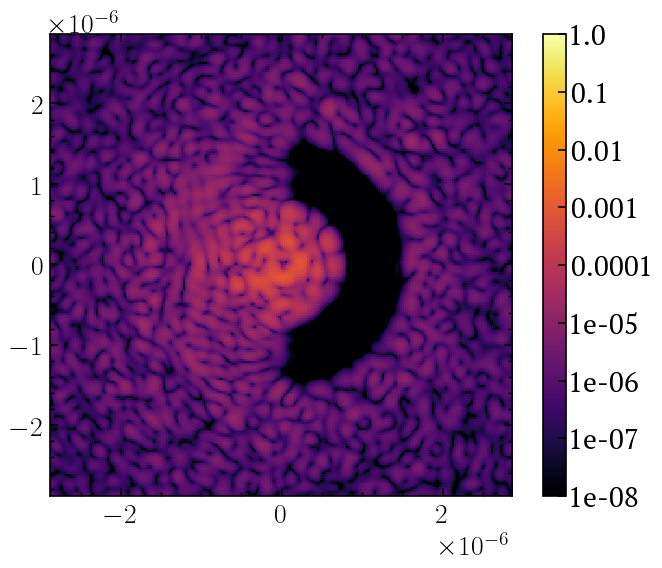

In [17]:
imshow_psf(img_cube[-1], vmax=1)